# Factor Research 

for FnGuide Replication 

FnGuide의 factor 백서에 나온 것을 최대한 반영하여 replicate.

이전에 daily rebalancing으로 구현한 것은 비슷한 모양이 나오긴 했지만 scale 차이가 매우 심했다. 

달라진 점:

- 리밸런싱 시점
    - Size & Book to Market (2 x 3): 연 1회 (7월 초)
- High/Medium/Low 구간
    - High: Top 30%
    - Medium: 30% ~ 70%
    - Low: 70% ~

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json

from pprint import pprint as pp

In [2]:
import quantstats as qs

In [3]:
cwd = Path.cwd()
data_dir = cwd / "data"
fnguide_dir = data_dir / "fnguide"
kqdl_dir = data_dir / "kqdl"
navernews_dir = data_dir / "navernews" / "navernews"

## 1. Import Dataset

학교에서 추출한 DataGuide 파일들을 불러오기

추출할 때 기간 내 delisted 종목도 포함시켰기 때문에 survivorship bias 적음.

In [4]:
## 추출한 fnguide 데이터를 dataframe으로 전처리

def preprocess_dataguide_csv(fn_file_name, cols, skiprows=8, encoding="cp949"):
    fn_df = pd.read_csv(fnguide_dir / fn_file_name, encoding=encoding, skiprows=skiprows, thousands=",")
    fn_df = fn_df.melt(id_vars=cols, var_name="date", value_name="value")

    return fn_df

In [5]:
fn_file_names = [
    'dataguide_kse+kosdaq_20140101-20231215_stc_pricevolume.CSV',
    'dataguide_kse+kosdaq_20140101-20231219_stc_mktcap.CSV',
    'dataguide_kse+kosdaq_20140101-20231219_foreigner.CSV',
    'dataguide_kse+kosdaq_20140101-20230207_industry.csv',
]

In [6]:
## 날짜가 아닌 컬럼들

cols = ['Symbol', 'Symbol Name', 'Kind', 'Item', 'Item Name ', 'Frequency',]

In [7]:
pricevolume_df = preprocess_dataguide_csv(fn_file_names[0], cols)
mktcap_df = preprocess_dataguide_csv(fn_file_names[1], cols)
foreigner_df = preprocess_dataguide_csv(fn_file_names[2], cols)
industry_df = preprocess_dataguide_csv(fn_file_names[3], cols, encoding="utf-8")

C:\Users\chlje\AppData\Local\Temp\ipykernel_19016\3952475545.py:4: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,

In [8]:
pricevolume_df['Item Name '].unique()

array(['수익률(%)', '수정주가(원)', '수정저가(원)', '수정고가(원)', '수정시가(원)', '거래량(주)',
       '거래대금(원)'], dtype=object)

In [9]:
mktcap_df['Item Name '].unique()

array(['시가총액 (티커-상장예정주식수 미포함)(백만원)'], dtype=object)

In [10]:
foreigner_df['Item Name '].unique()

array(['외국인보유비중(티커)(%)'], dtype=object)

In [11]:
industry_df['Item Name '].unique()

array(['FnGuide Sector Code', 'FnGuide Sector',
       'FnGuide Industry Group Code', 'FnGuide Industry Group',
       'FnGuide Industry Code', 'FnGuide Industry'], dtype=object)

In [12]:
pricevolume_df.info() # 원래 값이 "10,000" 와 같이 comma seperated string number로 되어있었음. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92848805 entries, 0 to 92848804
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Symbol       object 
 1   Symbol Name  object 
 2   Kind         object 
 3   Item         object 
 4   Item Name    object 
 5   Frequency    object 
 6   date         object 
 7   value        float64
dtypes: float64(1), object(7)
memory usage: 5.5+ GB


PBR 자료는 못 뽑아왔으므로, 자체 라이브러리인 `kqdl`을 통해 추출한 PBR 정보를 사용

In [13]:
kqdl_pbr = pd.read_pickle(kqdl_dir / "kqdl_pbr_20140101_20220531.pkl")

In [14]:
kqdl_pbr.head()

ticker,000020,000030,000040,000050,000060,000070,000075,000080,000087,000100,...,405640,406760,408920,409570,412930,413600,413630,415580,418170,419270
date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,0.55,NaN,0.82,0.41,1.38,0.48,0.0,1.09,0.0,1.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,0.56,NaN,0.83,0.42,1.37,0.47,0.0,1.08,0.0,1.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,0.56,NaN,0.83,0.43,1.37,0.47,0.0,1.09,0.0,1.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,0.56,NaN,0.82,0.43,1.37,0.48,0.0,1.09,0.0,1.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,0.58,NaN,0.83,0.42,1.37,0.48,0.0,1.08,0.0,1.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Transform dataset

퀀트 분석을 위한 panel 형태로 변환

In [15]:
def get_panel_df(df, item_name):
    panel_df = df.loc[df['Item Name '] == item_name].copy()
    panel_df = panel_df.pivot(index='date', columns='Symbol', values='value')
    panel_df = panel_df.reset_index()
    
    return panel_df

In [16]:
def transform_panel(panel_df, remove_holidays=True, drop_sid_prefix=True):
    panel_df = panel_df.set_index('date', inplace=False)
    panel_df.sort_index(inplace=True)

    if drop_sid_prefix:
        panel_df.columns = [sid[1:] for sid in panel_df.columns]

    if remove_holidays:
        panel_df = panel_df.dropna(how='all', axis=0)
    
    return panel_df

In [17]:
return_2d = transform_panel(get_panel_df(pricevolume_df, '수익률(%)'))
tradingmoneyvolume_2d = transform_panel(get_panel_df(pricevolume_df, '거래대금(원)'))
mktcap_2d = transform_panel(get_panel_df(mktcap_df, '시가총액 (티커-상장예정주식수 미포함)(백만원)'))
foreigner_2d = transform_panel(get_panel_df(foreigner_df, '외국인보유비중(티커)(%)'))


In [18]:
return_2d.tail(10)

,000010,000020,000030,000040,000050,000060,000070,000080,000090,000100,...,950110,950130,950140,950160,950170,950180,950190,950200,950210,950220
date,,,,,,,,,,,,,,,,,,,,,
2023-12-01,NaN,-0.84,NaN,-0.20,-0.35,NaN,0.00,1.58,NaN,0.33,...,0.23,10.10,2.36,0.00,0.00,NaN,1.66,-1.34,-0.50,0.73
2023-12-04,NaN,-0.85,NaN,1.38,1.05,NaN,0.14,1.34,NaN,-0.98,...,0.57,-1.48,0.32,-1.02,-0.51,NaN,1.45,2.13,-1.32,5.12
2023-12-05,NaN,2.14,NaN,0.19,-0.57,NaN,0.00,0.22,NaN,3.94,...,-1.35,26.23,2.93,-0.91,-1.55,NaN,-0.18,0.95,-0.82,7.81
2023-12-06,NaN,0.52,NaN,-2.72,1.85,NaN,0.14,0.66,NaN,1.42,...,1.37,-6.62,-0.69,-1.15,-2.09,NaN,8.94,0.56,-0.10,-0.75
2023-12-07,NaN,3.23,NaN,-0.60,-1.02,NaN,-1.58,0.00,NaN,2.02,...,0.56,-0.54,-1.63,-0.12,-1.20,NaN,-3.12,0.93,-1.66,1.29
2023-12-08,NaN,-0.30,NaN,1.00,0.92,NaN,0.88,-0.22,NaN,0.46,...,-0.45,-4.57,2.36,0.00,1.08,NaN,-1.27,1.30,0.53,-0.40
2023-12-11,NaN,-0.10,NaN,-0.20,0.23,NaN,0.43,1.09,NaN,-0.61,...,-0.23,-5.26,4.54,1.17,0.40,NaN,5.58,-1.83,0.00,-1.56
2023-12-12,NaN,0.71,NaN,0.20,-0.91,NaN,-0.86,0.65,NaN,0.15,...,6.67,-1.11,-3.46,-0.92,0.80,NaN,-4.31,1.49,1.57,-1.59
2023-12-13,NaN,-1.31,NaN,-0.99,0.69,NaN,-1.02,0.00,NaN,-1.53,...,3.92,-6.03,-0.91,-0.47,-0.93,NaN,-0.68,-5.50,-1.03,-1.67


## 3. Universe Filtering 

현실적인 포트폴리오 백테스팅을 위해 유동성 상위 2000 종목으로만 구성된 유니버스를 구성

이 때, 20일 평균 거래대금을 사용하여 일자별 변동을 줄임. (smooth univ 2000)

In [19]:
START_DATE = '2014-01-01'
END_DATE = '2022-05-31' # news dataset은 여기까지 있음. 

SUBUNIVERSE = 2000
UNIV_SMOOTHING_WINDOW = 20

In [20]:
tradingmoneyvolume_2d.index

Index(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07', '2014-01-08',
       '2014-01-09', '2014-01-10', '2014-01-13', '2014-01-14', '2014-01-15',
       ...
       '2023-12-01', '2023-12-04', '2023-12-05', '2023-12-06', '2023-12-07',
       '2023-12-08', '2023-12-11', '2023-12-12', '2023-12-13', '2023-12-14'],
      dtype='object', name='date', length=2450)

In [21]:
liquidity_rank_2d = tradingmoneyvolume_2d.rank(axis=1, method='dense', ascending=False)
smooth_liquidity_rank_2d = liquidity_rank_2d.rolling(UNIV_SMOOTHING_WINDOW).mean()

univ2000_2d = liquidity_rank_2d <= SUBUNIVERSE
smooth_univ2000_2d = smooth_liquidity_rank_2d <= SUBUNIVERSE

In [22]:
univ2000_2d.tail()

,000010,000020,000030,000040,000050,000060,000070,000080,000090,000100,...,950110,950130,950140,950160,950170,950180,950190,950200,950210,950220
date,,,,,,,,,,,,,,,,,,,,,
2023-12-08,False,True,False,False,False,False,True,True,False,True,...,False,True,True,True,True,False,True,True,True,True
2023-12-11,False,True,False,False,False,False,True,True,False,True,...,False,True,True,True,False,False,True,True,True,True
2023-12-12,False,True,False,False,False,False,True,True,False,True,...,True,True,True,True,False,False,True,False,True,True
2023-12-13,False,True,False,False,False,False,True,True,False,True,...,True,True,True,True,False,False,True,True,True,True
2023-12-14,False,True,False,True,False,False,True,True,False,True,...,True,True,True,True,False,False,True,True,True,True


In [23]:
# 모든 데이터셋에 smooth_univ2000 mask 적용

return_2d = return_2d.loc[START_DATE:END_DATE][smooth_univ2000_2d]
tradingmoneyvolume_2d = tradingmoneyvolume_2d.loc[START_DATE:END_DATE][smooth_univ2000_2d]
mktcap_2d = mktcap_2d.loc[START_DATE:END_DATE][smooth_univ2000_2d]
foreigner_2d = foreigner_2d.loc[START_DATE:END_DATE][smooth_univ2000_2d]


In [24]:
pbr_2d = kqdl_pbr.loc[START_DATE:END_DATE][smooth_univ2000_2d]

In [25]:
return_2d = return_2d * 0.01 # % -> decimal

In [26]:
return_2d.dropna(axis=1, how='all', inplace=True)
tradingmoneyvolume_2d.dropna(axis=1, how='all', inplace=True)
mktcap_2d.dropna(axis=1, how='all', inplace=True)
foreigner_2d.dropna(axis=1, how='all', inplace=True)

In [27]:
pbr_2d.dropna(axis=1, how='all', inplace=True)

In [28]:
return_2d.shape

(2069, 2582)

In [29]:
pbr_2d.shape

(2069, 2542)

DataGuide에서 뽑은 데이터와 내가 KRX에서 가져온 데이터와 일부 유니버스 차이가 있다. 

In [30]:
fnguide_universe = set(return_2d.columns)
kqdl_universe = set(pbr_2d.columns)

In [31]:
len(fnguide_universe - kqdl_universe)

40

In [32]:
len(kqdl_universe - fnguide_universe)

0

In [33]:
fnguide_universe - kqdl_universe

{'067370',
 '084440',
 '148780',
 '198940',
 '210120',
 '221800',
 '232830',
 '246250',
 '303360',
 '900040',
 '900050',
 '900070',
 '900080',
 '900090',
 '900100',
 '900110',
 '900120',
 '900130',
 '900140',
 '900180',
 '900250',
 '900260',
 '900270',
 '900280',
 '900290',
 '900300',
 '900310',
 '900340',
 '950010',
 '950100',
 '950110',
 '950130',
 '950140',
 '950160',
 '950170',
 '950180',
 '950190',
 '950200',
 '950210',
 '950220'}

일부 정상 종목이 포함되지 않는 경우가 있었고, 9로 시작하는 코드들이 대부분 빠졌다. 

빠진 종목들 중 시가총액이 큰 종목이 있진 않다.

종목코드는 언젠가 변화할 수 있는 대상이므로, 제대로 된 분석에선 자체적인 security id 부여가 필요하다. 

관련 기사: 

거래소, 주권·ETN 종목코드 체계 개편... 알파벳 혼용해 중복 방지 (23/05/23)

https://news.mt.co.kr/mtview.php?no=2023052314210810155

In [34]:
# # Make checkpoint

# return_2d.to_pickle(fnguide_dir / 'return_2d.pkl')
# tradingmoneyvolume_2d.to_pickle(fnguide_dir / 'tradingmoneyvolume_2d.pkl')
# mktcap_2d.to_pickle(fnguide_dir / 'mktcap_2d.pkl')
# foreigner_2d.to_pickle(fnguide_dir / 'foreigner_2d.pkl')

In [35]:
# read checkpoint 만들기

더 작은 kqdl universe 기준으로 맞춰 분석을 진행한다. 


In [36]:
return_2d = return_2d.loc[:, list(kqdl_universe)].copy()
tradingmoneyvolume_2d = tradingmoneyvolume_2d.loc[:, list(kqdl_universe)].copy()
mktcap_2d = mktcap_2d.loc[:, list(kqdl_universe)].copy()
foreigner_2d = foreigner_2d.loc[:, list(kqdl_universe)].copy()

In [37]:
return_2d.shape

(2069, 2542)

In [38]:
pbr_2d.shape

(2069, 2542)

## 4. Factor Portfolio 

Fama-French 3 Factor Portfolio를 만들어 벤치마크(=단순 시가총액 가중 포트폴리오=마켓팩터)와 수익률 비교

In [39]:
return_1dshift = return_2d.shift(-1)

시그널은 다음 날부터 사용할 수 있으므로, 백테스팅 할 때는 return에 1 day shift를 준다. 

이것을 수행하지 않을 시 forward looking (=look-ahead bias)이 되어 아예 잘못된 결과가 나온다. 

### A. Market factor

$$ R_m - R_f $$ 

`Rf`는 기준금리 series 데이터가 따로 필요하므로 일단 상수로 가정

이 경우 Sharpe 지수는 신뢰하기 어렵게 됨.

In [40]:
RISK_FREE = 0.04 / 252 # 1년 4% 수익률을 252일로 나눔

In [41]:
cap_weight = mktcap_2d.div(mktcap_2d.sum(axis=1), axis=0)
Rm = (return_1dshift - RISK_FREE).mul(cap_weight).sum(axis=1)

In [42]:
Rm.index = pd.to_datetime(Rm.index)

<Axes: title={'center': 'Market Factor Portfolio'}, xlabel='date'>

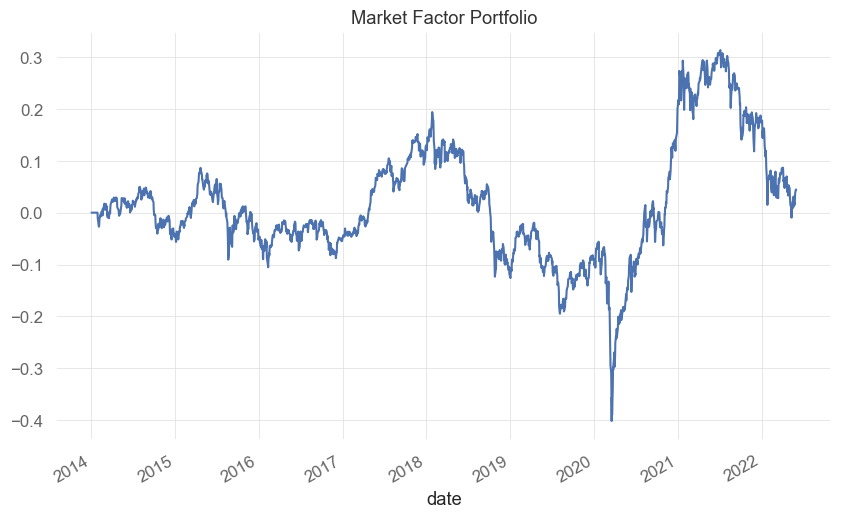

In [43]:
((1+Rm).cumprod()-1).plot(title='Market Factor Portfolio')

### B. HML

High Minus Low

$$
\text{HML} = \frac{1}{2} \left( (S_{\text{high}} + B_{\text{high}}) - (S_{\text{low}} + B_{\text{low}}) \right)
$$

Fama French는 Big & Small (2 가지) * Low & Medium & High (3가지) = 6개의 포트폴리오가 생김. 

각 포트폴리오는 equal-weight가 아닌 value-weight임. 

In [44]:
big_2d = mktcap_2d.rank(axis=1, method='dense', ascending=False, pct=True) <= 0.5
small_2d = mktcap_2d.rank(axis=1, method='dense', ascending=False, pct=True) > 0.5

# Fama-French는 Book-to-Market이기 때문에 PBR이 높을수록 Book-to-Market이 low, 낮을수록 high가 됨. 
low_2d = pbr_2d.rank(axis=1, method='dense', ascending=False, pct=True) <= 1/3
medium_2d = (pbr_2d.rank(axis=1, method='dense', ascending=False, pct=True) > 1/3) \
    & (pbr_2d.rank(axis=1, method='dense', ascending=False, pct=True) <= 2/3)
high_2d = pbr_2d.rank(axis=1, method='dense', ascending=False, pct=True) > 2/3

Sanity check: 대표적 가치주인 은행주가 정상적으로 high book-to-market (low PBR)에 들어있는지 확인해보자. 

- 신한지주055550
- KB금융105560
- 우리금융지주316140

In [45]:
high_firms = high_2d.iloc[-1, :]
high_firms = high_firms[high_firms].index

len(high_firms)

1367

In [46]:
'055550' in high_firms

True

In [47]:
'105560' in high_firms

True

In [48]:
'316140' in high_firms

True

이제 Fama French factor 정의에 맞게 2*3 으로 포트폴리오를 나눈다. 

In [169]:
S_low = (small_2d & low_2d).astype(float)
S_mid = (small_2d & medium_2d).astype(float)
S_high = (small_2d & high_2d).astype(float)

B_low = (big_2d & low_2d).astype(float)
B_mid = (big_2d & medium_2d).astype(float)
B_high = (big_2d & high_2d).astype(float)

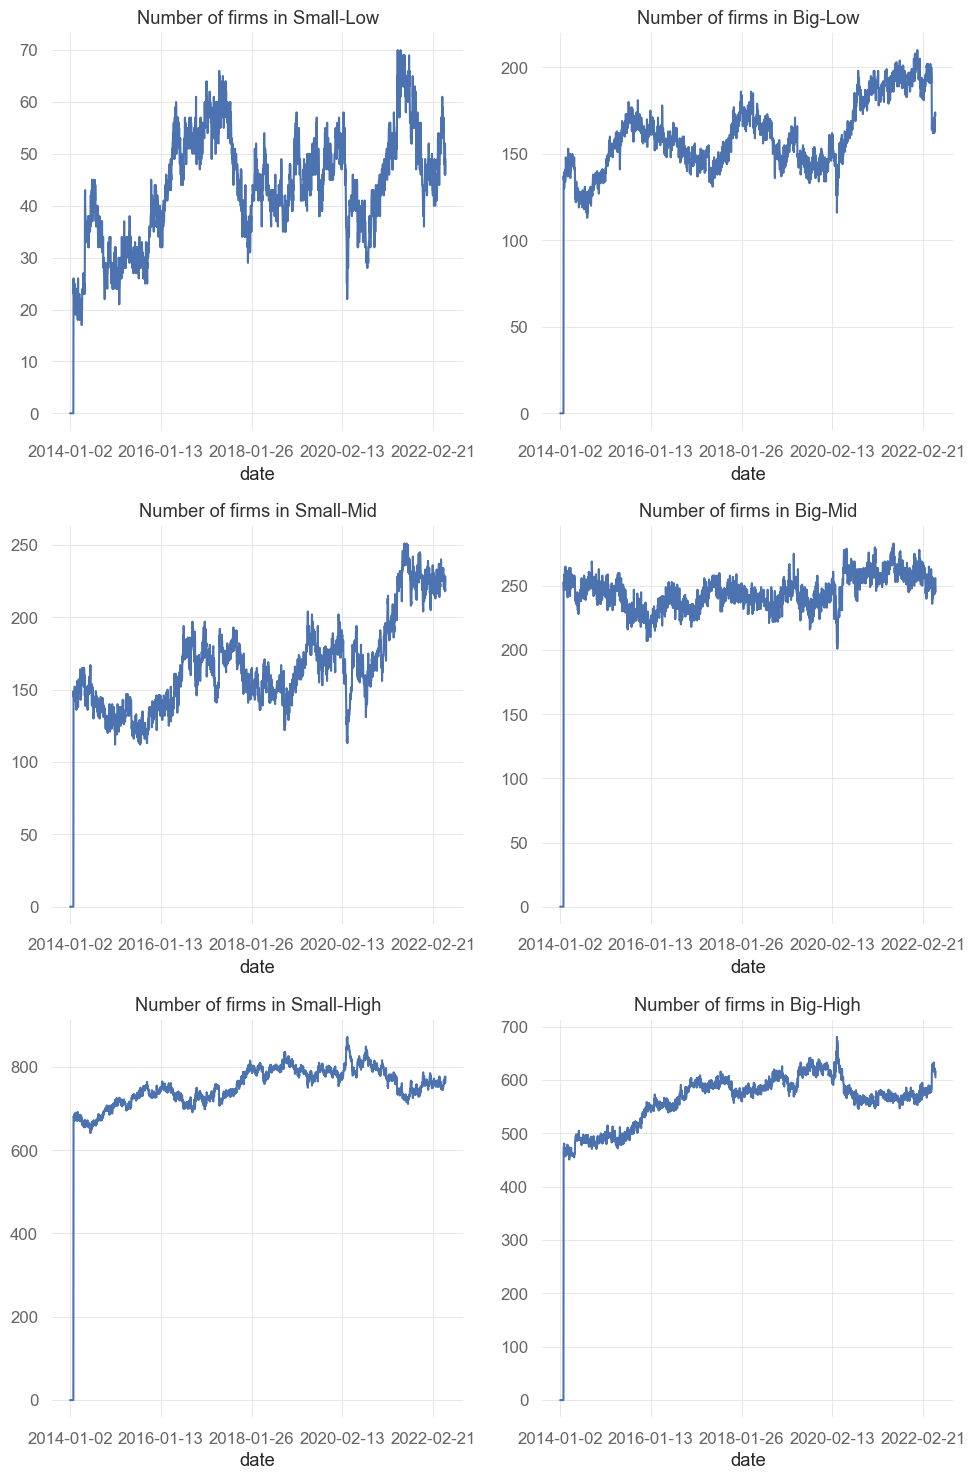

In [50]:
# Create a 3x2 subplot grid
fig, axs = plt.subplots(3, 2, figsize=(10, 15))

# Flatten the axs array for easy iteration
axs_flat = axs.flatten()

# Titles for each subplot
titles = ['Number of firms in Small-Low', 'Number of firms in Big-Low', 
          'Number of firms in Small-Mid', 'Number of firms in Big-Mid',
          'Number of firms in Small-High', 'Number of firms in Big-High',
          ]

# Data for each subplot
data = [S_low, B_low, S_mid, B_mid, S_high, B_high]

# Loop through the data to create each subplot
for ax, datum, title in zip(axs_flat, data, titles):
    datum.sum(axis=1).plot(ax=ax)
    ax.set_title(title)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


In [170]:
# Give NaN to False, so that they are not included in each subuniverse at all.

S_low = S_low.replace(0, np.nan)
S_mid = S_mid.replace(0, np.nan)
S_high = S_high.replace(0, np.nan)

B_low = B_low.replace(0, np.nan)
B_mid = B_mid.replace(0, np.nan)
B_high = B_high.replace(0, np.nan)

각 분류 내에서 cap weight를 해야 하므로, rescale이 필요함. 


In [52]:
# 모두 양수/음수일 때 0~1 사이로 스케일링
# TODO: 양수/음수 섞인 long-short 일 때도 스케일링 가능하도록 처리 (절대값 이용)
def scale_row(row):
    if row.sum() == 0:
        return row
    return row / row.sum()

def scale_2d(df):
    return df.apply(scale_row, axis=1)

In [53]:
# NOT masks they are weights. It's very confusing. Fix it. 
# TODO: Fix misleading variable name. Its not a mask. 

S_low_mask = scale_2d(S_low * cap_weight)
S_mid_mask = scale_2d(S_mid * cap_weight)
S_high_mask = scale_2d(S_high * cap_weight)

B_low_mask = scale_2d(B_low * cap_weight)
B_mid_mask = scale_2d(B_mid * cap_weight)
B_high_mask = scale_2d(B_high * cap_weight)


매년 7월 리밸런싱으로 변경

In [365]:
# TODO: rebalance frequency를 받아 월 1회, 뭐 분기당 한 번 이런 식으로 가능하도록. 
# 임시로 yearly만 대충 넣어놓음. 
def rebalance_returns(mask_2d, return_1dshift, rebalance_month=7):
    if not rebalance_month:
        port = mask_2d * return_1dshift
        port_returns = port.sum(axis=1)
        port_cumreturns = (1+port_returns).cumprod() - 1

        return port_cumreturns
    
    mask_2d = mask_2d.copy()
    mask_2d.index = pd.to_datetime(mask_2d.index)

    cap_weight_ = cap_weight.copy()
    cap_weight_.index = pd.to_datetime(cap_weight.index)

    filtered = mask_2d[ mask_2d.index.month == rebalance_month ]
    rebalance_dates = filtered.groupby(filtered.index.year).apply(lambda x: x.index.max())
    rebalance_2d = mask_2d.loc[rebalance_dates, :]
    
    rebalance_capweight = cap_weight.loc[rebalance_dates, :]

    weighted_rebalance = scale_2d(rebalance_2d * rebalance_capweight)
    weighted_rebalance = weighted_rebalance.fillna(-1)

    rebalanced_mask_2d = pd.DataFrame(index=mask_2d.index, columns=mask_2d.columns)
    rebalanced_mask_2d.loc[rebalance_dates, :] = weighted_rebalance
    
    rebalanced_mask_2d = rebalanced_mask_2d.ffill()
    rebalanced_mask_2d = rebalanced_mask_2d.replace(-1, np.nan)

    # rebalanced_capweight = scale_2d(rebalanced_mask_2d * cap_weight) # 여기도 index가 하나는 datetime, 하나는 str라서 곱했더니 row가 두 배 됨. 
    rebalanced_capweight = scale_2d(rebalanced_mask_2d * cap_weight_)

    port = rebalanced_capweight.values * return_1dshift.values # index가 하나는 datetime index, 하나는 str여서. 
    
    port_returns = pd.Series(np.nansum(port, axis=1))
    port_returns.index = mask_2d.index

    return port_returns

In [350]:
mask_2d = S_low
rebalance_month = 7

mask_2d = mask_2d.copy()
mask_2d.index = pd.to_datetime(mask_2d.index)

In [351]:
cap_weight = cap_weight.copy()
cap_weight.index = pd.to_datetime(cap_weight.index)

filtered = mask_2d[ mask_2d.index.month == rebalance_month ]
rebalance_dates = filtered.groupby(filtered.index.year).apply(lambda x: x.index.max())
rebalance_2d = mask_2d.loc[rebalance_dates, :]

rebalance_capweight = cap_weight.loc[rebalance_dates, :]

weighted_rebalance = scale_2d(rebalance_2d * rebalance_capweight)
weighted_rebalance = weighted_rebalance.fillna(-1)

In [354]:
(weighted_rebalance != -1).sum().sum()

366

In [355]:
rebalanced_mask_2d = pd.DataFrame(index=mask_2d.index, columns=mask_2d.columns)
rebalanced_mask_2d.loc[rebalance_dates, :] = weighted_rebalance
rebalanced_mask_2d = rebalanced_mask_2d.ffill()

In [358]:
rebalanced_mask_2d = rebalanced_mask_2d.replace(-1, np.nan)

In [361]:
rebalanced_capweight = scale_2d(rebalanced_mask_2d * cap_weight)

In [332]:
weighted_rebalance = scale_2d(rebalance_2d * rebalance_capweight)

In [342]:
rebalanced_mask_2d = pd.DataFrame(index=mask_2d.index, columns=mask_2d.columns)
rebalanced_mask_2d.loc[rebalance_dates, :] = weighted_rebalance
rebalanced_mask_2d = rebalanced_mask_2d.ffill()

<Axes: xlabel='date'>

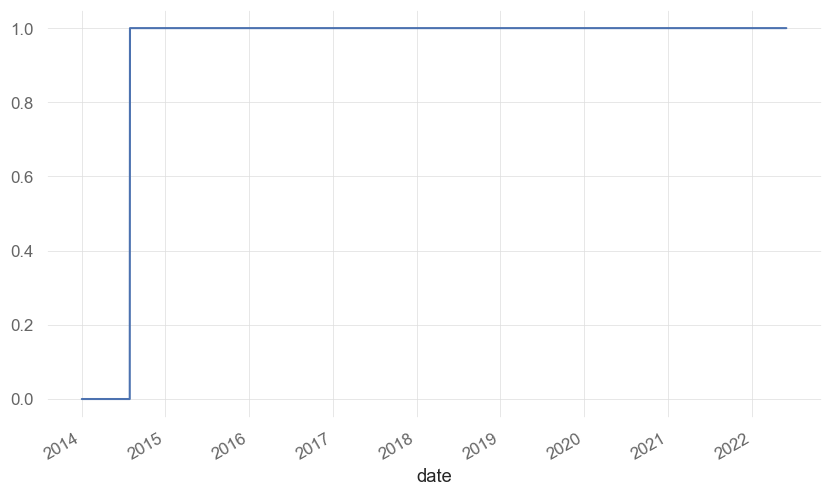

In [362]:
(rebalanced_capweight).sum(axis=1).plot()

<Axes: xlabel='date'>

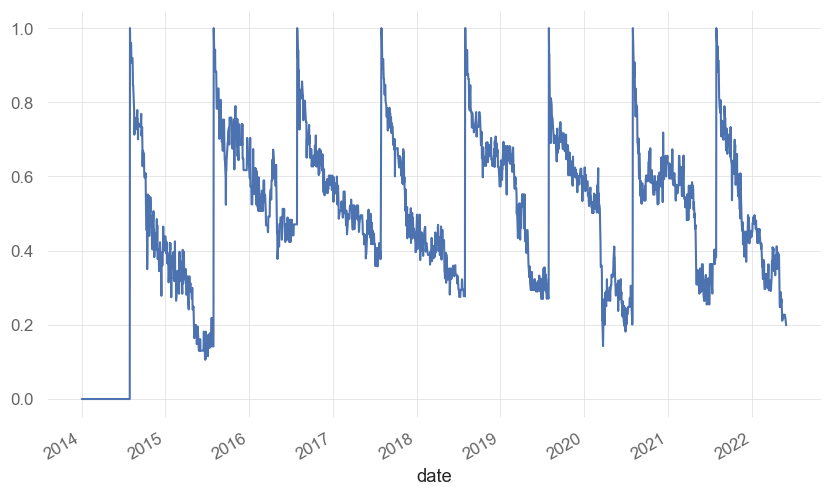

In [ ]:
(rebalanced_mask_2d * mask_2d).sum(axis=1).plot()

In [261]:
def get_cumreturn(return_series):
    return (1+return_series).cumprod()-1

In [366]:
S_high_port_return = rebalance_returns(S_high, return_1dshift)
S_mid_port_return = rebalance_returns(S_mid, return_1dshift)
S_low_port_return = rebalance_returns(S_low, return_1dshift)

B_high_port_return = rebalance_returns(B_high, return_1dshift)
B_mid_port_return = rebalance_returns(B_mid, return_1dshift)
B_low_port_return = rebalance_returns(B_low, return_1dshift)

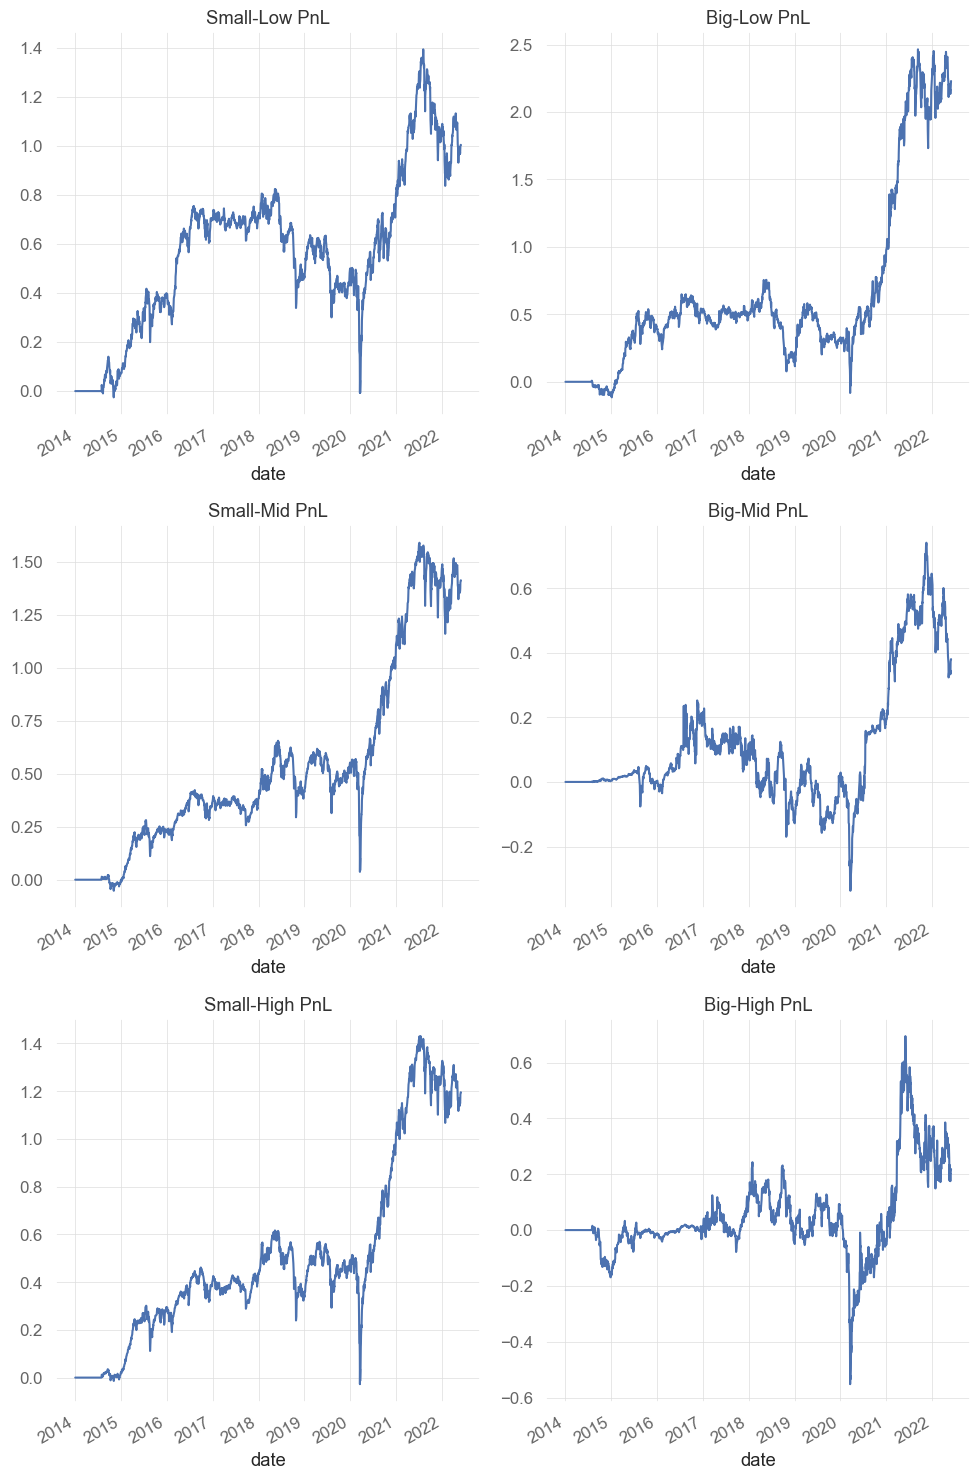

In [367]:
# Create a 3x2 subplot grid
fig, axs = plt.subplots(3, 2, figsize=(10, 15))

# Flatten the axs array for easy iteration
axs_flat = axs.flatten()

# Titles for each subplot
titles = [
    'Small-Low PnL', 'Big-Low PnL',
    'Small-Mid PnL', 'Big-Mid PnL',
    'Small-High PnL', 'Big-High PnL',
    ]

# Data for each subplot
data = [
    S_low_port_return, B_low_port_return, 
    S_mid_port_return, B_mid_port_return, 
    S_high_port_return, B_high_port_return,
    ]

# Loop through the data to create each subplot
for ax, datum, title in zip(axs_flat, data, titles):
    get_cumreturn(datum).plot(ax=ax)
    ax.set_title(title)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


In [368]:
High_port_return = S_high_port_return + B_high_port_return
Low_port_return = S_low_port_return + B_low_port_return

HML = (High_port_return - Low_port_return) * 1/2

In [369]:
HML.index = pd.to_datetime(HML.index)

<Axes: title={'center': 'Value Factor Portfolio'}, xlabel='date'>

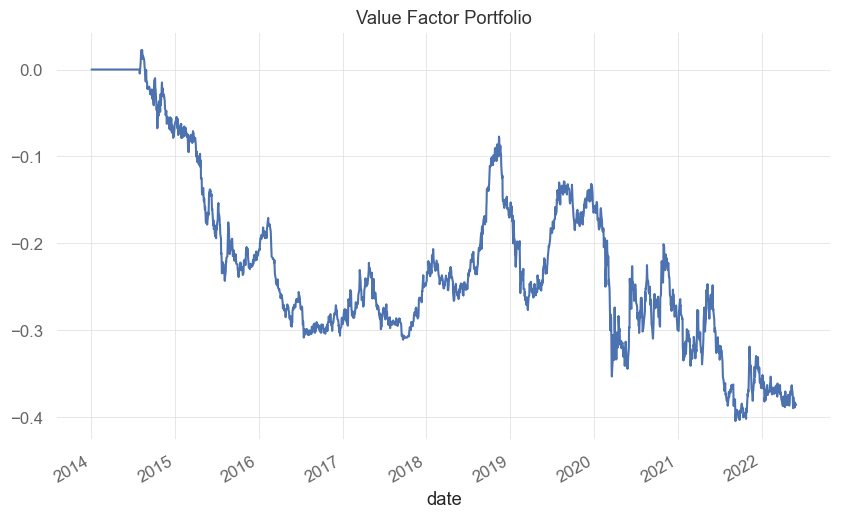

In [370]:
get_cumreturn(HML).plot(title='Value Factor Portfolio')

### C. SMB

Small Minus Big

$$
\text{SMB} = \frac{1}{3} \left( (S_{\text{low}} + S_{\text{mid}} + S_{\text{high}}) - (B_{\text{low}} + B_{\text{mid}} + B_{\text{high}}) \right)

$$

In [371]:
Small_portfolio = S_low_port_return + S_mid_port_return + S_high_port_return
Big_portfolio = B_low_port_return + B_mid_port_return + B_high_port_return

SMB = (Small_portfolio - Big_portfolio) * 1/3

In [372]:
SMB.index = pd.to_datetime(SMB.index)

<Axes: title={'center': 'Size Factor Portfolio'}, xlabel='date'>

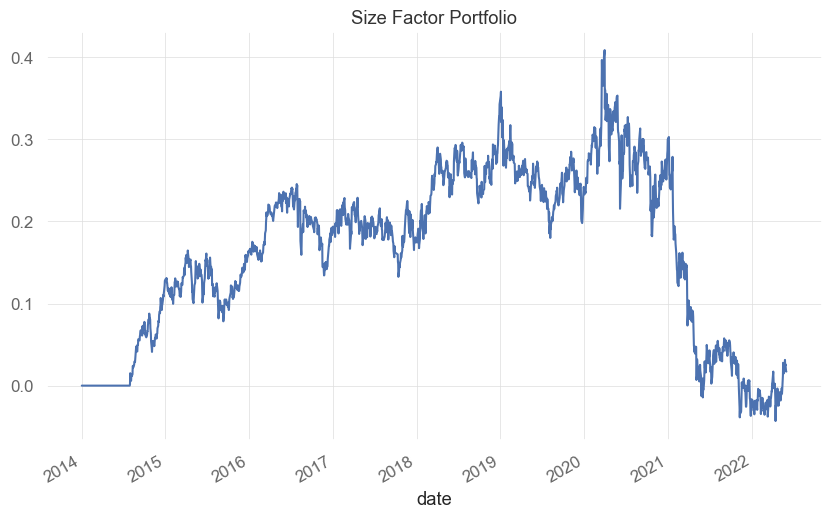

In [373]:
get_cumreturn(SMB).plot(title='Size Factor Portfolio')

### 세 가지 팩터 종합

Text(0.5, 1.0, 'Factor Portfolios')

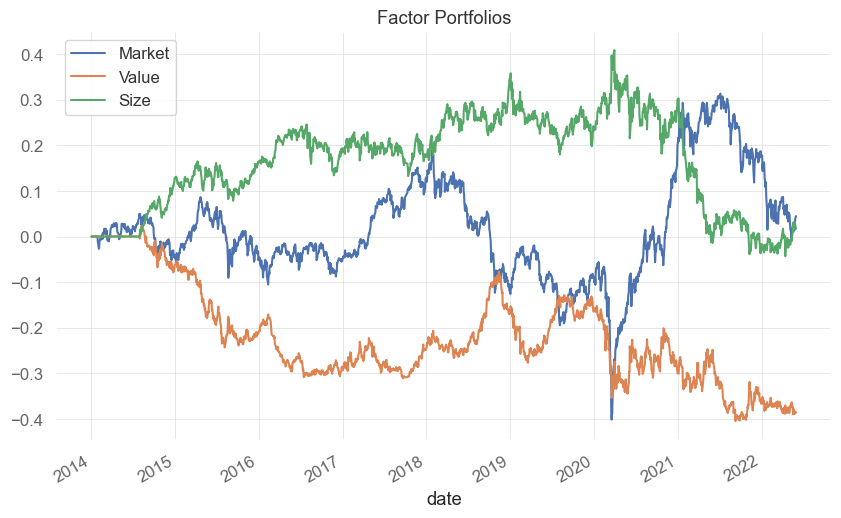

In [374]:
get_cumreturn(Rm).plot(label='Market')
get_cumreturn(HML).plot(label='Value')
get_cumreturn(SMB).plot(label='Size')

plt.legend()
plt.title('Factor Portfolios')

Text(0.5, 1.0, 'Factor Portfolios')

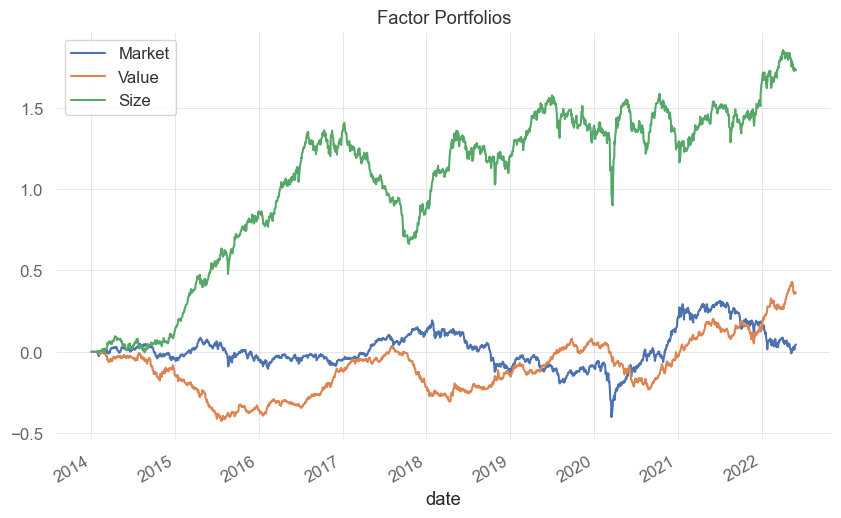

In [ ]:
get_cumreturn(Rm).plot(label='Market')
get_cumreturn(HML).plot(label='Value')
get_cumreturn(SMB).plot(label='Size')

plt.legend()
plt.title('Factor Portfolios')

차라리 스케일은 안맞더라도 이게 더 정답에 가까움. 

### FnGuide FF3 데이터와 비교

DataGuide에서 FF3의 HML, SMB 팩터 수익률을 추출하여 비교

In [70]:
fn_ff3_df = pd.read_csv(fnguide_dir / 'korea_ff3_smb_hml.csv')
fn_ff3_df

,Symbol,3FM.2B3.HML,3FM.2B3.SMB
0,1990-07-04,0.05,0.31
1,1990-07-05,0.29,-0.16
2,1990-07-06,0.29,-0.48
3,1990-07-07,0.06,-0.27
4,1990-07-09,-0.15,-1.04
...,...,...,...
8704,2024-03-04,1.24,-0.67
8705,2024-03-05,-0.05,0.25
8706,2024-03-06,-0.43,0.18
8707,2024-03-07,-0.38,-1.03


In [71]:
fn_ff3_df.columns = ['date', 'fn_HML', 'fn_SMB']

In [72]:
fn_ff3_df['date'] = pd.to_datetime(fn_ff3_df['date'])
fn_ff3_df.set_index('date', inplace=True)

In [73]:
fn_ff3_df = fn_ff3_df.astype(float)

In [74]:
fn_ff3_df = fn_ff3_df / 100

In [317]:
# FF_START_DATE = return_1dshift.dropna(axis=0, how='all').index[0]
FF_START_DATE = '2014-07-31'

FF_END_DATE = return_1dshift.dropna(axis=0, how='all').index[-1]

In [318]:
fn_ff3_df = fn_ff3_df.loc[FF_START_DATE:FF_END_DATE]

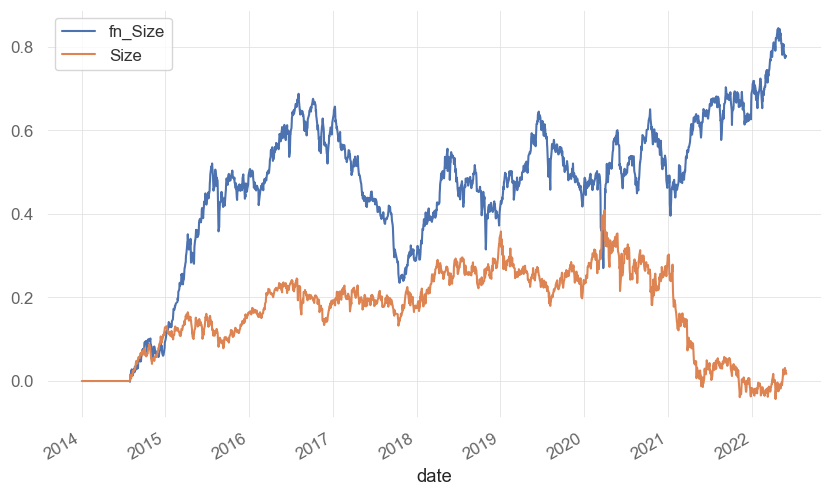

In [375]:
get_cumreturn(fn_ff3_df['fn_SMB']).plot(label='fn_Size')
get_cumreturn(SMB).plot(label='Size')
plt.legend()

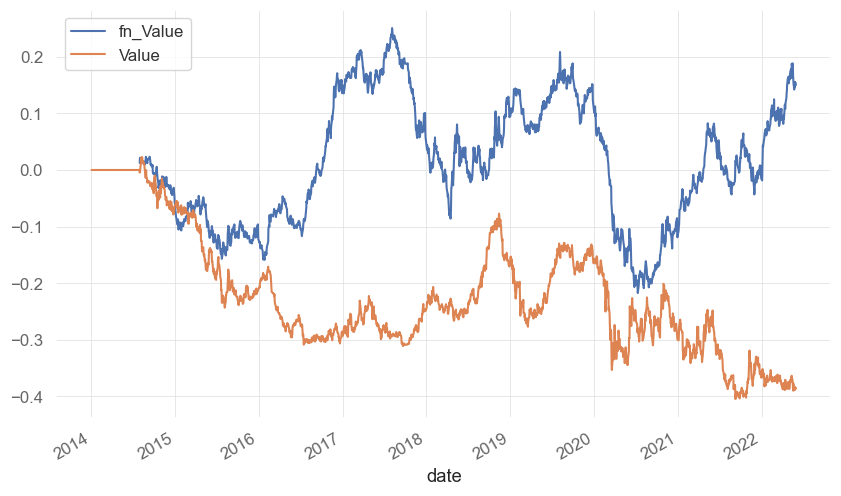

In [376]:
get_cumreturn(fn_ff3_df['fn_HML']).plot(label='fn_Value')
get_cumreturn(HML).plot(label='Value')
plt.legend()

완전 다름. 아예 FnGuide랑 상이하게 나옴. 

벌어질 것이면 계속 벌어져야지, 중간에 벌어졌다 다시 줄어드는 것이 이해가 잘 안된다. 

전체적인 up and down은 비슷한 것 같은데, 세부적으로 correlation 찍어보면 그건 또 굉장히 차이가 많이 난다.

## 5. Factor Portfolio 성과분석 상세

`quantstats` 이용

f:\VSCodeProjects\qtrsch\.venv\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
f:\VSCodeProjects\qtrsch\.venv\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
f:\VSCodeProjects\qtrsch\.venv\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=

                           Strategy
-------------------------  ----------
Start Period               2014-01-02
End Period                 2022-05-31
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          173.26%
CAGR﹪                     8.6%

Sharpe                     0.98
Prob. Sharpe Ratio         99.69%
Smart Sharpe               0.86
Sortino                    1.37
Smart Sortino              1.2
Sortino/√2                 0.97
Smart Sortino/√2           0.85
Omega                      1.18

Max Drawdown               -30.9%
Longest DD Days            813
Volatility (ann.)          13.42%
Calmar                     0.28
Skew                       -0.71
Kurtosis                   8.73

Expected Daily %           0.05%
Expected Monthly %         1.0%
Expected Yearly %          11.82%
Kelly Criterion            8.64%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.34%
Expected Shortfall (cVaR)  -1.34%

Max Consecutive Wins       1

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2017-01-10,2017-10-17,2019-04-02,813,-30.901954,-29.892166
2,2019-07-04,2020-03-23,2020-10-12,467,-26.238570,-23.829391
3,2020-10-14,2021-01-08,2021-12-28,441,-16.344281,-13.826175
4,2015-07-24,2015-08-20,2015-09-11,50,-9.609071,-8.586593
5,2014-04-16,2014-08-22,2014-12-09,238,-9.034259,-8.395919


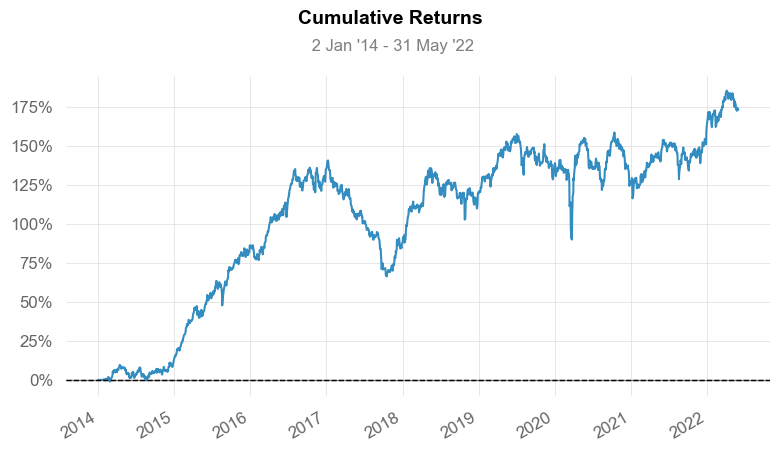

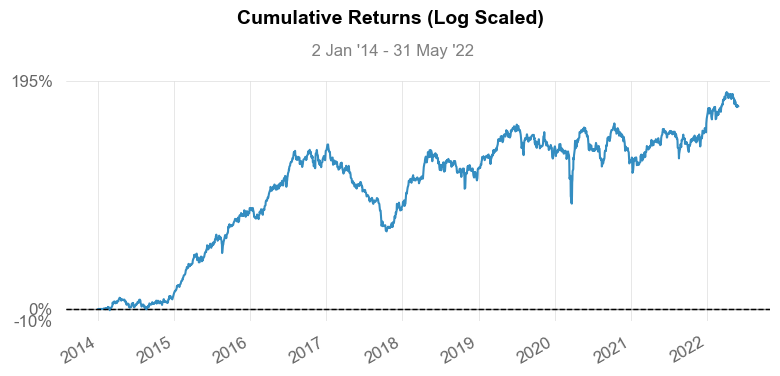

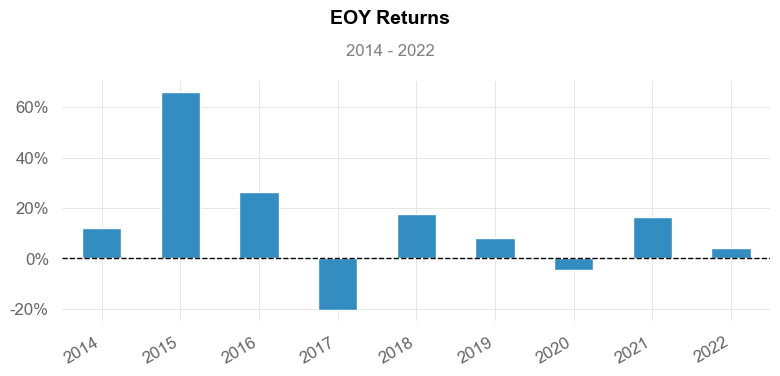

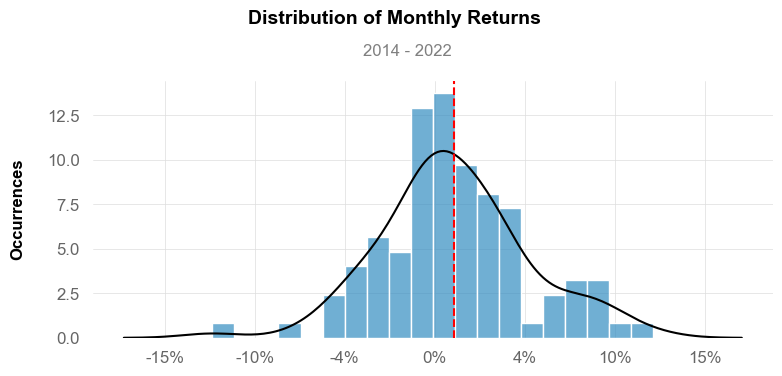

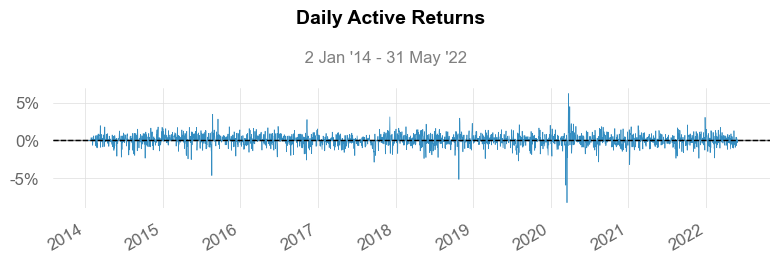

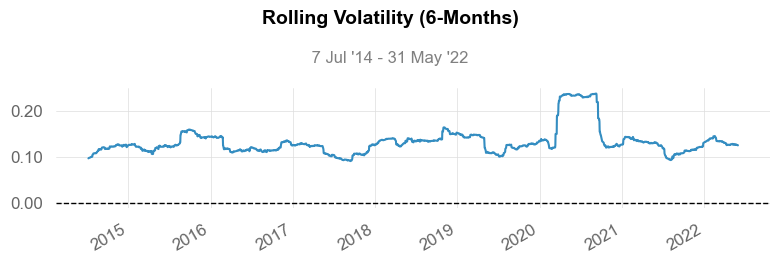

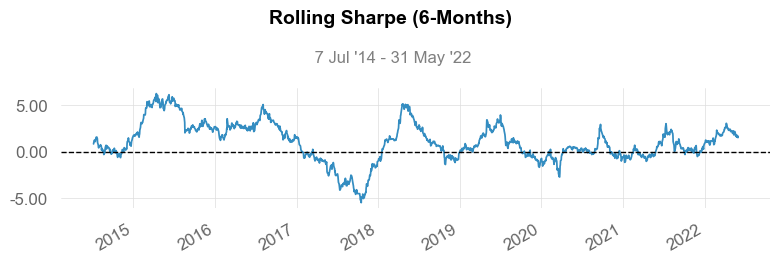

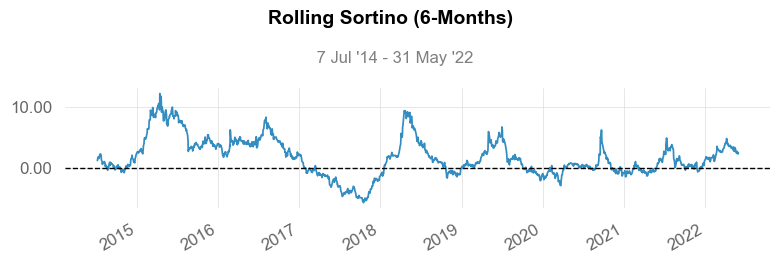

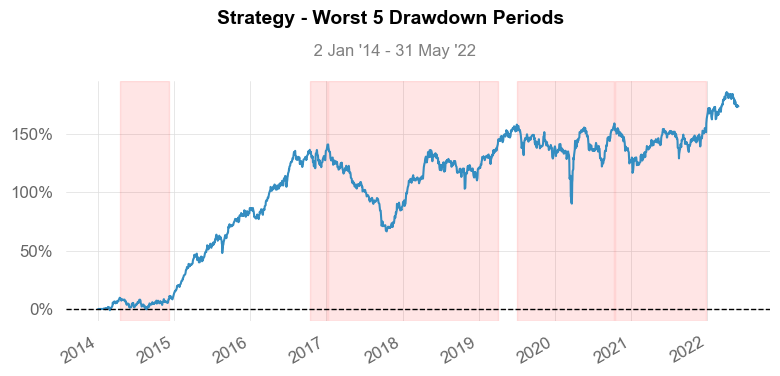

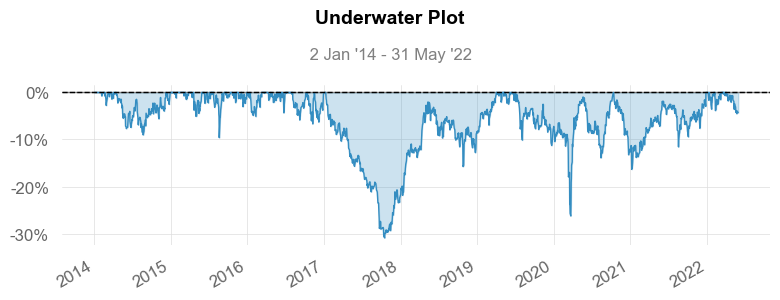

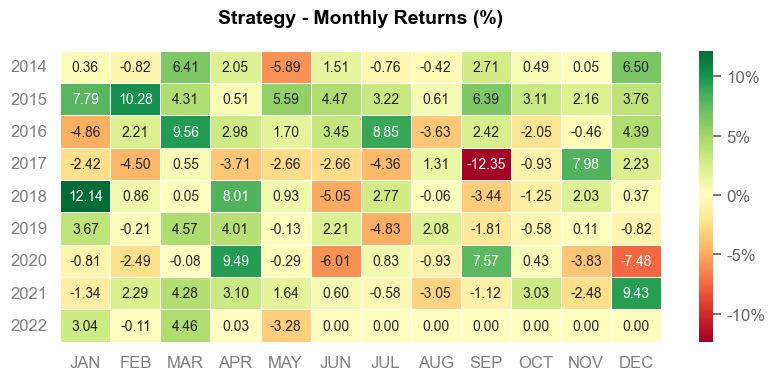

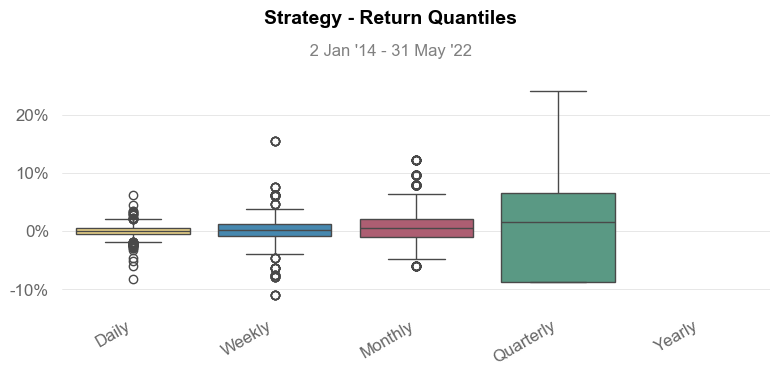

In [79]:
qs.reports.full(SMB)